In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

In [2]:
def getDisparity(image_left, image_right):
    
    image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
    image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
    window_size = 9
    min_disp = -21
    num_disp = 160
    
#     sbm.SADWindowSize = 9;
#     sbm.numberOfDisparities = 96;
#     sbm.preFilterCap = 63;
#     sbm.minDisparity = -21;
#     sbm.uniquenessRatio = 7;
#     sbm.speckleWindowSize = 0;
#     sbm.speckleRange = 8;
#     sbm.disp12MaxDiff = 1;
#     sbm.fullDP = False;

    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        disp12MaxDiff = 1,
        uniquenessRatio = 7,
        speckleWindowSize = 0,
        speckleRange = 8
        )
    
    disparity = stereo.compute(image_left, image_right).astype(np.float32) / 16.0
    disparity = (disparity-min_disp)/num_disp
    
    return disparity

In [3]:
def getPoses():
    poses = []
    with open("poses.txt","r") as f:
        lines = f.readlines()
        for line in lines:
            row = line.split(" ")
#             row.extend([0,0,0,1])
            row = np.array(row).astype('float64')
            poses.append(row.reshape((3, 4)))
#             poses.append(row.reshape((4, 4)))
            
#     poses = np.linalg.inv(poses[0]) @ poses
#     poses = poses[:, :3, :]
    
#     print(poses[0])
    return poses

In [4]:
def project_points(points, colors, K, P, width, height):
    
    R = P[:, :3]
    R[:, 1] *= -1
    t = P[:, 3]
    
    dist_coeff = np.zeros((4, 1))
    projected, _ = cv2.projectPoints(points, R, t, K, dist_coeff)

    ones_row = np.ones((points.shape[0], 1))

#     print(points.shape, ones_row.shape)
    
    points = np.concatenate((points, ones_row), axis = 1)
    print(K.shape, P.shape, points.T.shape)
    
    camera_projected = P @ points.T
    camera_projected = camera_projected.T.astype(np.int)
    
    xy = projected.reshape(-1, 2). astype(np.int)
#     print(xy.shape)
    mask = (
        (0 <= xy[:, 0]) & (xy[:, 0] < width) &
        (0 <= xy[:, 1]) & (xy[:, 1] < height)
    )
    
    img_coord = xy[mask]
    img_color = colors[mask]
    
    camera_color = colors
    
    return camera_projected, camera_color, img_coord, img_color

In [5]:
def getParallaxMap(disparity):
    parallax_map = []
    x, y = disparity.shape
    
    for i in range(x):
        for j in range(y):
            parallax_map.append([j, i, disparity[i, j], 1])
            
    return np.array(parallax_map)

In [6]:
def reprojectImageTo3D(Q, parallax_mat):
    points_3D = Q @ parallax_mat.T
    points_3D /= points_3D[3, :]
    points_3D = points_3D[:3, :]
    points_3D = points_3D.T
    
    print(points_3D.shape)
    output = np.zeros((370, 1226, 3))
    i = 0
    j = 0
    
    for p in range(points_3D.shape[0]):
        output[i][j] = points_3D[p]
        j += 1
        
        if j >= 1226:
            j = 0
            i += 1
        
    
    print(output.shape)
    return output

In [7]:
def getImage(points, color, height, width):
    image = np.zeros((height, width, 3), dtype=color.dtype)
    image[points[:, 1], points[:, 0]] = color
    return image

(370, 1226)


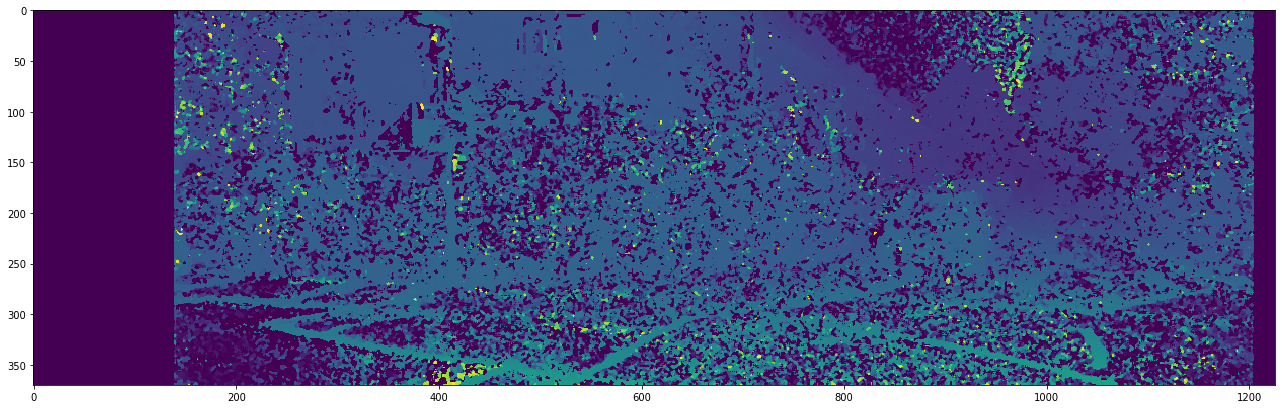

In [8]:
image_left = cv2.imread('img2/0000000461.png')
image_right = cv2.imread('img3/0000000461.png')

# image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
# image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)

disparity = getDisparity(image_left, image_right)

w = disparity.shape[0]
l = disparity.shape[1]

print(disparity.shape)
plt.subplots_adjust(right=3, top=3)
plt.imshow(disparity)
plt.show()

In [9]:
focal_length = 7.070912e+02
baseline = 0.53790448812
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], [0.000000e+00, 7.070912e+02, 1.831104e+02], [0.000000e+00, 0.000000e+00, 1.000000e+00]])
poses = getPoses()

Q = np.array([
        [1, 0, 0, -l/2],
        [0, 1, 0, -w/2],
        [0, 0, 0, focal_length],
        [0, 0, -1/baseline, 0]
    ])

# Q = np.array([
#         [baseline, 0, 0, 0],
#         [0, baseline, 0, 0],
#         [0, 0, baseline * focal_length, 0],
#         [0, 0, 0, -1]
#     ])

all_pts = np.array([]).reshape(0,3)
all_colors = np.array([]).reshape(0,3)
for i in range(460, 481):
    image_left = cv2.imread('img2/0000000{}.png'.format(i))
    image_right = cv2.imread('img3/0000000{}.png'.format(i))

    disparity = getDisparity(image_left, image_right)
    parallax_map = getParallaxMap(disparity)
    points_3D = reprojectImageTo3D(Q, parallax_map)
#     points_3D = cv2.reprojectImageTo3D(disparity, Q)
#     print(points_3D.shape)

    mask_map = disparity > disparity.min()

    colors = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)

    output_points = points_3D[mask_map]
    output_colors = colors[mask_map]
    
    camera_projected, camera_color, img_coords, img_color = project_points(output_points, output_colors, K, poses[i-460], l, w)
    
    all_pts = np.concatenate((all_pts, camera_projected), axis=0)
    all_colors = np.concatenate((all_colors, camera_color), axis=0)
    
    print(img_coords.shape)
    img = getImage(img_coords, img_color, w, l)
    cv2.imwrite("img" + str(i) + ".png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 317051)
(215484, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul


(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 321727)
(226507, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 313037)
(237397, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 320944)
(255513, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 315375)
(266925, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 308067)
(273486, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 320593)
(291325, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 320808)
(295351, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 316198)
(291795, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 313971)
(290879, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 309373)
(285651, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 305144)
(272297, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 304773)
(253630, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 303917)
(245502, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 304721)
(234903, 2)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 305316)
(221495, 2)
(453620, 3)
(370, 1226, 3

In [10]:
print(all_pts.shape)
print(np.amax(all_pts))
print(all_colors.shape)
print(np.amax(all_colors))

(6502333, 3)
138215.0
(6502333, 3)
255.0


In [19]:
mask = (
        (-3000 <= all_pts[:, 0]) & (all_pts[:, 0] < 3000) &
        (-3000 <= all_pts[:, 1]) & (all_pts[:, 1] < 3000) & 
        (-900 <= all_pts[:, 2]) & (all_pts[:, 2] < 900)
    )

plot_pts = all_pts[mask]
plot_pts[:, 1] *= -1
plot_colors = (all_colors[mask]/255.0).astype(float)
# print(plot_colors[:100, :])
pcd = o3d.geometry.PointCloud()
vis = o3d.visualization.Visualizer()
pcd.points = o3d.utility.Vector3dVector(plot_pts) #numpy_points is your Nx3 cloud
pcd.colors = o3d.utility.Vector3dVector(plot_colors) #numpy_colors is an Nx3 matrix with the corresponding RGB colors
# vis.create_window()
# vis.add_geometry(pcd)
# opt = vis.get_render_option()
# opt.background_color = np.asarray([0, 0, 0])
# vis.run()
o3d.visualization.draw_geometries([pcd])